# 

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import numpy as np
import torch

# dust3r_path = str(Path(os.path.join(os.getcwd())).parent / "dust3r" / "dust3r")
# sys.path.append(dust3r_path)
sys.path.append("../../dust3r")
sys.path.append("../..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from src.annotated.dust3r.dust3r import AnnotatedAsymmetricCroCo3DStereo
from dust3r.model import AsymmetricCroCo3DStereo

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [11]:
device = "cpu"
batch_size = 1
schedule = "cosine"
lr = 0.01
niter = 300

model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
original_model = AsymmetricCroCo3DStereo.from_pretrained(model_name)
# you can put the path to a local checkpoint in model_name if needed
model = AnnotatedAsymmetricCroCo3DStereo.from_pretrained_naver_DUSt3R_ViTLarge_BaseDecoder_512_dpt(original_model)


Verifying model weights...
All weights verified to be identical


In [13]:
import sys

import numpy as np
import torch

sys.path.append("../..")

from src.dust3r.load_images import LoadConfig, load_images

In [16]:
images_data = load_images(["../assets/Chateau1.png", "../assets/Chateau2.png"], config=LoadConfig(size=512))

INFO:src.dust3r.load_images:>> Loading 2 images.
INFO:src.dust3r.load_images: - Added ../assets/Chateau1.png with resolution 512x512
INFO:src.dust3r.load_images: - Added ../assets/Chateau2.png with resolution 512x512
INFO:src.dust3r.load_images: (Successfully loaded 2 images)


In [18]:
from src.dust3r.make_pairs import make_pairs

In [19]:
pairs = make_pairs(images_data)

### Inference

In [20]:
from src.dust3r.inference import collate_with_cat, inference, loss_of_one_batch

In [21]:
batch_size = 2
dict_pairs = [(p[0].to_dict(), p[1].to_dict()) for p in pairs]
collated_dict_pairs = collate_with_cat(dict_pairs[0:batch_size])

In [22]:
output = loss_of_one_batch(collated_dict_pairs, model, criterion=None, device=device)

ic| self.__class__.__name__: 'VisionTransformerEncoderV2'
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| patch_positions.shape: torch.Size([1, 1024, 2])
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| self.__class__.__name__: 'VisionTransformerEncoderV2'
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| patch_positions.shape: torch.Size([1, 1024, 2])
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| reference_image_tokens.shape: torch.Size([2, 1024, 768])
ic| query_for_normalized_source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| key_for_normalized_source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| value_for_normalized_source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| source_image_token_positions.shape: torch.Size([2, 1024, 2])
ic| source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| reference_image_tokens.shape: torch.Size([2, 1024, 768])
ic| query_for_normalized_sourc

In [24]:
output = inference(pairs, model, device, batch_size=batch_size)

>> Inference with model on 2 image pairs


  0%|          | 0/1 [00:00<?, ?it/s]ic| self.__class__.__name__: 'VisionTransformerEncoderV2'
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| patch_positions.shape: torch.Size([1, 1024, 2])
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| self.__class__.__name__: 'VisionTransformerEncoderV2'
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| patch_positions.shape: torch.Size([1, 1024, 2])
ic| image_patches.shape: torch.Size([1, 1024, 1024])
ic| source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| reference_image_tokens.shape: torch.Size([2, 1024, 768])
ic| query_for_normalized_source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| key_for_normalized_source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| value_for_normalized_source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| source_image_token_positions.shape: torch.Size([2, 1024, 2])
ic| source_image_tokens.shape: torch.Size([2, 1024, 768])
ic| reference_image_tokens.shape: torch.Size([2, 1024,

## Global Alignment

In [26]:
from src.dust3r.optimizer import PointCloudOptimizer

view1, pred1 = output["view1"], output["pred1"]
view2, pred2 = output["view2"], output["pred2"]

In [27]:
# this is the relative distance computed up to a scale factor
print(torch.min(pred1["pts3d"]), torch.max(pred1["pts3d"]))
print(torch.min(pred2["pts3d_in_other_view"]), torch.max(pred2["pts3d_in_other_view"]))

tensor(-0.5505) tensor(2.6927)
tensor(-1.4045) tensor(2.0823)


In [28]:
# this is computed as conf = 1 + exp(conf_for_network_output)
print(torch.min(pred1["conf"]), torch.max(pred1["conf"]))
print(torch.min(pred2["conf"]), torch.max(pred2["conf"]))

tensor(1.) tensor(26.2093)
tensor(1.) tensor(22.1474)


In [29]:
scene = PointCloudOptimizer(view1, view2, pred1, pred2, device=device).to(device)

In [31]:
import roma
import torch.nn as nn
from src.dust3r.minimum_spanning_tree import geotrf, get_med_dist_between_poses, init_minimum_spanning_tree
from src.dust3r.utils import xy_grid, signed_expm1, signed_log1p

loss = scene.compute_global_alignment_v2(init="mst", niter=300, schedule=schedule, lr=lr)

 init edge (1*,0*) score=27.618152618408203
 init loss = 4.527844794210978e-05
Global alignement - optimizing for:
['pw_poses', 'pw_adaptors', 'im_poses', 'im_depthmaps', 'im_focals']


100%|██████████| 300/300 [00:08<00:00, 33.49it/s, lr=1.27413e-06 loss=7.63864e-06]


In [32]:
scene.show(viewer="gl")

2025-03-20 22:20:16.148 python[20475:30442741] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-20 22:20:16.284 python[20475:30442741] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [35]:
assert len(scene.imgs) == 2
assert scene.imgs[0].shape == (512, 512, 3), f"scene.imgs[0].shape: {scene.imgs[0].shape}"
assert len(scene.get_pts3d()) == 2
assert scene.get_pts3d()[0].shape == torch.Size(
    [512, 512, 3]
), f"scene.get_pts3d()[0].shape: {scene.get_pts3d()[0].shape}"
assert len(scene.get_masks()) == 2
assert scene.get_masks()[0].shape == torch.Size(
    [512, 512]
), f"scene.get_masks()[0].shape: {scene.get_masks()[0].shape}"

In [36]:
# retrieve useful values from scene:
imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

In [37]:
# find 2D-2D matches between the two images
from dust3r.utils.geometry import find_reciprocal_matches, xy_grid

pts2d_list, pts3d_list = [], []
for i in range(2):
    conf_i = confidence_masks[i].cpu().numpy()
    pts2d_list.append(xy_grid(*imgs[i].shape[:2][::-1])[conf_i])  # imgs[i].shape[:2] = (H, W)
    pts3d_list.append(pts3d[i].detach().cpu().numpy()[conf_i])

In [39]:
# assert imgs[0].shape[:2][::-1] == (512, 384)

# assert confidence_masks[0].cpu().numpy().shape == (384, 512)
# assert xy_grid(*imgs[0].shape[:2][::-1]).shape == (384, 512, 2)
# assert pts3d[0].detach().cpu().numpy().shape == (384, 512, 3)

# # number of points selected for 2d should be the same as the mask where pixels are True
# assert np.sum(confidence_masks[0].cpu().numpy()) == len(pts2d_list[0])
# assert np.sum(confidence_masks[0].cpu().numpy()) == len(pts3d_list[0])

# assert imgs[1].shape[:2][::-1] == (512, 384)

# assert confidence_masks[1].cpu().numpy().shape == (384, 512)
# assert xy_grid(*imgs[1].shape[:2][::-1]).shape == (384, 512, 2)
# assert pts3d[1].detach().cpu().numpy().shape == (384, 512, 3)

# # number of points selected for 2d should be the same as the mask where pixels are True
# assert np.sum(confidence_masks[1].cpu().numpy()) == len(pts2d_list[1])
# assert np.sum(confidence_masks[1].cpu().numpy()) == len(pts3d_list[1])

In [40]:
reciprocal_in_P2, nn2_in_P1, num_matches = find_reciprocal_matches(*pts3d_list)
print(f"found {num_matches} matches")
matches_im1 = pts2d_list[1][reciprocal_in_P2]
matches_im0 = pts2d_list[0][nn2_in_P1][reciprocal_in_P2]

found 33514 matches


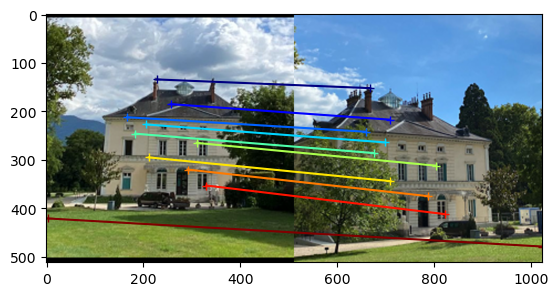

: 

In [41]:
# visualize a few matches
import numpy as np
from matplotlib import pyplot as pl

n_viz = 10
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = (
    matches_im0[match_idx_to_viz],
    matches_im1[match_idx_to_viz],
)

H0, W0, H1, W1 = *imgs[0].shape[:2], *imgs[1].shape[:2]
img0 = np.pad(imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), "constant", constant_values=0)
img1 = np.pad(imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), "constant", constant_values=0)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap("jet")
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot(
        [x0, x1 + W0],
        [y0, y1],
        "-+",
        color=cmap(i / (n_viz - 1)),
        scalex=False,
        scaley=False,
    )
pl.show(block=True)